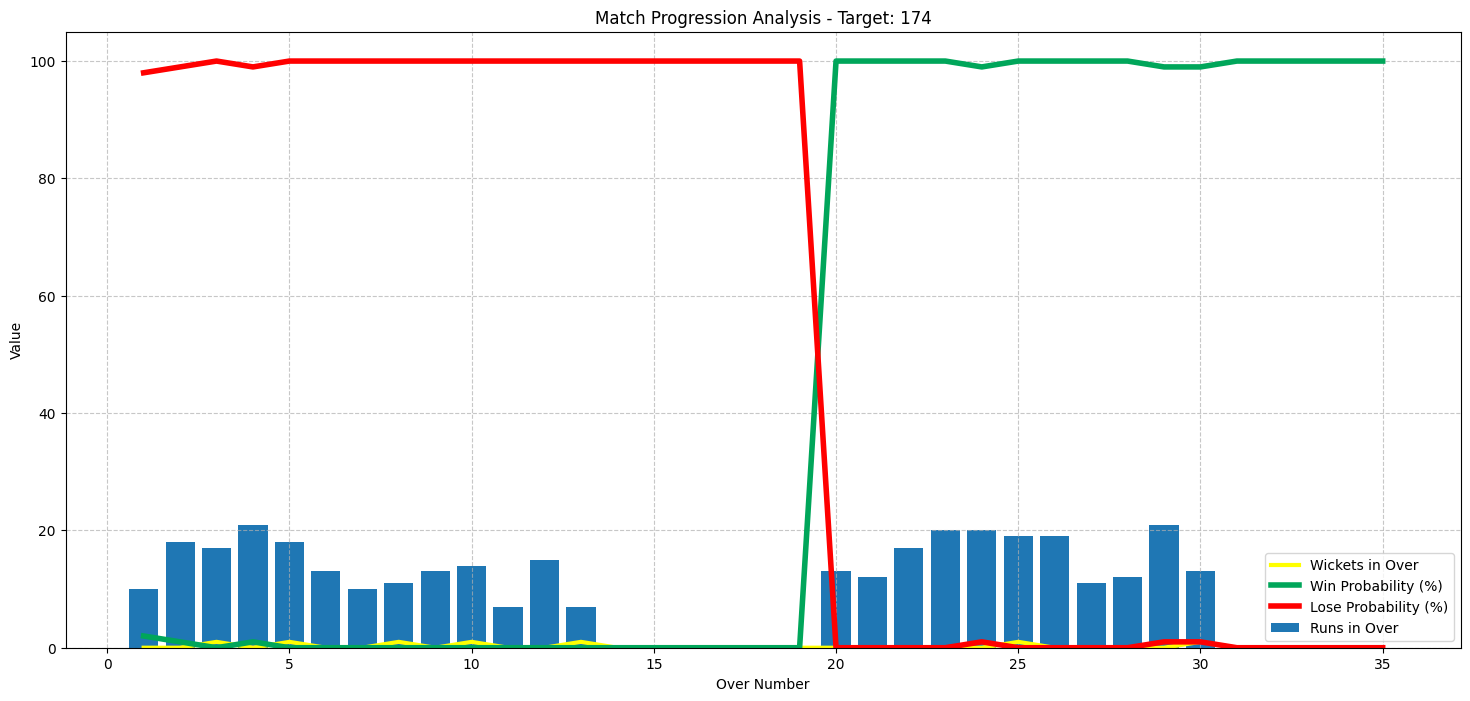

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import pickle
from joblib import dump, load

deliveries = pd.read_csv('dataset/deliveries.csv')
matches = pd.read_csv('dataset/matches.csv')
ipl_2025 = pd.read_csv('dataset/processed/ipl_2025_raw.csv')

ipl_2025_completed = ipl_2025[
    (ipl_2025['Status'] == 'Completed') & 
    (ipl_2025['Winner'] != 'TBD') &
    (ipl_2025['Team1_Runs'].notna()) &
    (ipl_2025['Team2_Runs'].notna())
].copy()

venue_to_city_map = {
    "M. Chinnaswamy Stadium": "Bangalore",
    "Sawai Mansingh Stadium": "Jaipur",
    "Wankhede Stadium": "Mumbai",
    "BRSABV Ekana Cricket Stadium": "Lucknow",
    "PCA New Stadium, Mullanpur": "Mohali",
    "Eden Gardens": "Kolkata",
    "Rajiv Gandhi Intl. Cricket Stadium": "Hyderabad",
    "M. A. Chidambaram Stadium": "Chennai",
    "Narendra Modi Stadium": "Ahmedabad",
    "Arun Jaitley Stadium": "Delhi"
}

team_name_map = {
    "Royal Challengers Bengaluru": "Royal Challengers Bangalore"
}

max_match_id = matches['id'].max() if not matches.empty else 0
start_id = max_match_id + 1

matches_2025 = []
for idx, match in ipl_2025_completed.iterrows():
    match_id = start_id + idx
    team1 = team_name_map.get(match['Team1'], match['Team1'])
    team2 = team_name_map.get(match['Team2'], match['Team2'])
    winner = team_name_map.get(match['Winner'], match['Winner'])
    city = venue_to_city_map.get(match['Venue'], "Unknown")
    target_runs = match['Team1_Runs'] + 1
    
    if match['WonBy'] == 'Runs':
        win_by_runs = match['Margin']
        win_by_wickets = 0
    else:
        win_by_runs = 0
        win_by_wickets = match['Margin']
    
    matches_2025.append({
        'id': match_id,
        'city': city,
        'date': match['Date'],
        'team1': team1,
        'team2': team2,
        'toss_winner': match['Toss_Winner'],
        'toss_decision': match['Toss_Decision'],
        'result': match['WonBy'],
        'dl_applied': 0,
        'winner': winner,
        'win_by_runs': win_by_runs,
        'win_by_wickets': win_by_wickets,
        'player_of_match': match['Player_of_Match'],
        'venue': match['Venue'],
        'umpire1': match['Umpire1'],
        'umpire2': match['Umpire2'],
        'umpire3': match['Third_Umpire'],
        'target_runs': target_runs
    })

matches_2025_df = pd.DataFrame(matches_2025)

deliveries_2025 = []
for idx, match in ipl_2025_completed.iterrows():
    match_id = start_id + idx
    team1 = team_name_map.get(match['Team1'], match['Team1'])
    team2 = team_name_map.get(match['Team2'], match['Team2'])
    
    team1_overs = match['Team1_Overs']
    team1_balls = int(team1_overs) * 6 + int((team1_overs % 1) * 10)
    team1_runs = match['Team1_Runs']
    team1_wickets = match['Team1_Wickets']
    
    avg_runs_per_ball_team1 = team1_runs / team1_balls if team1_balls > 0 else 0
    wicket_frequency = team1_balls // team1_wickets if team1_wickets > 0 else team1_balls + 1
    runs_scored = 0
    
    for ball_num in range(1, team1_balls + 1):
        over = (ball_num - 1) // 6
        ball_in_over = ((ball_num - 1) % 6) + 1
        is_wicket = 1 if (ball_num % wicket_frequency == 0) and (runs_scored < team1_runs) else 0
        
        if ball_num == team1_balls:
            ball_runs = team1_runs - runs_scored
        else:
            ball_runs = min(np.random.poisson(avg_runs_per_ball_team1 * 1.5), team1_runs - runs_scored)
            
        runs_scored += ball_runs
        
        deliveries_2025.append({
            'match_id': match_id,
            'inning': 1,
            'batting_team': team1,
            'bowling_team': team2,
            'over': over,
            'ball': ball_in_over,
            'batsman': f"Batsman_Team1_{ball_num % 11}",
            'bowler': f"Bowler_Team2_{over % 5}",
            'non_striker': f"NonStriker_Team1_{(ball_num + 1) % 11}",
            'is_super_over': 0,
            'wide_runs': 0,
            'bye_runs': 0,
            'legbye_runs': 0,
            'noball_runs': 0,
            'penalty_runs': 0,
            'batsman_runs': ball_runs,
            'extra_runs': 0,
            'total_runs': ball_runs,
            'player_dismissed': is_wicket
        })
    
    team2_overs = match['Team2_Overs']
    team2_balls = int(team2_overs) * 6 + int((team2_overs % 1) * 10)
    team2_runs = match['Team2_Runs']
    team2_wickets = match['Team2_Wickets']
    
    avg_runs_per_ball_team2 = team2_runs / team2_balls if team2_balls > 0 else 0
    wicket_frequency = team2_balls // team2_wickets if team2_wickets > 0 else team2_balls + 1
    runs_scored = 0
    
    for ball_num in range(1, team2_balls + 1):
        over = (ball_num - 1) // 6
        ball_in_over = ((ball_num - 1) % 6) + 1
        is_wicket = 1 if (ball_num % wicket_frequency == 0) and (runs_scored < team2_runs) else 0
        
        if ball_num == team2_balls:
            ball_runs = team2_runs - runs_scored
        else:
            ball_runs = min(np.random.poisson(avg_runs_per_ball_team2 * 1.5), team2_runs - runs_scored)
            
        runs_scored += ball_runs
        
        deliveries_2025.append({
            'match_id': match_id,
            'inning': 2,
            'batting_team': team2,
            'bowling_team': team1,
            'over': over,
            'ball': ball_in_over,
            'batsman': f"Batsman_Team2_{ball_num % 11}",
            'bowler': f"Bowler_Team1_{over % 5}",
            'non_striker': f"NonStriker_Team2_{(ball_num + 1) % 11}",
            'is_super_over': 0,
            'wide_runs': 0,
            'bye_runs': 0,
            'legbye_runs': 0,
            'noball_runs': 0,
            'penalty_runs': 0,
            'batsman_runs': ball_runs,
            'extra_runs': 0,
            'total_runs': ball_runs,
            'player_dismissed': is_wicket
        })

deliveries_2025_df = pd.DataFrame(deliveries_2025)

all_matches = pd.concat([matches, matches_2025_df], ignore_index=True)
all_deliveries = pd.concat([deliveries, deliveries_2025_df], ignore_index=True)

teams = [
    'Royal Challengers Bangalore',
    'Mumbai Indians',
    'Kolkata Knight Riders',
    'Lucknow Super Giants',
    'Rajasthan Royals',
    'Chennai Super Kings',
    'Delhi Capitals',
    'Sunrisers Hyderabad',
    'Gujarat Titans',
    'Punjab Kings'
]

team_replacements = {
    'Delhi Daredevils': 'Delhi Capitals',
    'Deccan Chargers': 'Sunrisers Hyderabad',
    'Kings XI Punjab': 'Punjab Kings',
    'Gujarat Lions': 'Gujarat Titans',
    'Royal Challengers Bengaluru': 'Royal Challengers Bangalore'
}

for old_name, new_name in team_replacements.items():
    all_matches['team1'] = all_matches['team1'].str.replace(old_name, new_name)
    all_matches['team2'] = all_matches['team2'].str.replace(old_name, new_name)
    all_matches['winner'] = all_matches['winner'].str.replace(old_name, new_name)
    all_deliveries['batting_team'] = all_deliveries['batting_team'].str.replace(old_name, new_name)
    all_deliveries['bowling_team'] = all_deliveries['bowling_team'].str.replace(old_name, new_name)

all_matches = all_matches[all_matches['team1'].isin(teams)]
all_matches = all_matches[all_matches['team2'].isin(teams)]

total_score = all_deliveries.groupby(['match_id', 'inning', 'batting_team'])['total_runs'].sum().reset_index()
total_score = total_score[total_score['inning'] == 1]
match_df = all_matches.merge(total_score, left_on='id', right_on='match_id')
match_df = match_df[['id', 'city', 'winner', 'total_runs', 'inning']]
delivery_df = match_df.merge(all_deliveries, left_on='id', right_on='match_id')
delivery_df = delivery_df.drop('inning_x', axis=1)
delivery_df = delivery_df.rename(columns={'inning_y': 'inning'})

delivery_df['total_runs_y'] = delivery_df['total_runs_y'].fillna(0)
delivery_df['total_runs_y'] = pd.to_numeric(delivery_df['total_runs_y'], errors='coerce')
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']
delivery_df['balls_left'] = 120 - (delivery_df['over'] * 6 + delivery_df['ball'])
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna(0)
delivery_df['player_dismissed'] = pd.to_numeric(delivery_df['player_dismissed'], errors='coerce').fillna(0).astype(int)
wickets = delivery_df.groupby('match_id')['player_dismissed'].cumsum().values
delivery_df['wickets'] = 10 - wickets
delivery_df['crr'] = (delivery_df['current_score'] * 6) / (120 - delivery_df['balls_left'])
delivery_df['rrr'] = (delivery_df['runs_left'] * 6) / (delivery_df['balls_left'])
delivery_df['rrr'] = delivery_df['rrr'].replace([np.inf, -np.inf], 20)

def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

delivery_df['result'] = delivery_df.apply(result, axis=1)
final_df = delivery_df[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 
                        'wickets', 'total_runs_x', 'crr', 'rrr', 'result']]
final_df = final_df.sample(frac=1, random_state=42)
final_df = final_df[final_df['balls_left'] > 0]
final_df = final_df.dropna()
final_df = final_df.replace([np.inf, -np.inf], 20)

X = final_df.iloc[:, :-1]
y = final_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

cat = ['batting_team', 'bowling_team', 'city']
num = ['runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']

pre = ColumnTransformer(
    transformers=[('one-hot-encoding', OneHotEncoder(handle_unknown='ignore', drop='first'), cat)],
    remainder='passthrough'
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
pipe = Pipeline(steps=[('preprocessing', pre), ('model', model)])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
report = classification_report(y_test, y_pred)

pickle.dump(pipe, open('pipe_updated_2025.pkl', 'wb'))
dump(pipe, 'model_new_2025.joblib')

def match_progression(delivery_df, match_id, pipe):
    match = delivery_df[delivery_df['match_id'] == match_id]
    match = match[match['ball'] == 6]
    
    temp_df = match[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 
                     'wickets', 'total_runs_x', 'crr', 'rrr']].dropna()
    
    temp_df = temp_df[temp_df['balls_left'] != 0]
    
    if temp_df.empty:
        return None, None
    
    result = pipe.predict_proba(temp_df)
    
    temp_df['lose'] = np.round(result.T[0] * 100, 1)
    temp_df['win'] = np.round(result.T[1] * 100, 1)
    
    temp_df['end_of_over'] = range(1, temp_df.shape[0] + 1)
    
    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0, target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0, 10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    temp_df = temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']]
    
    return temp_df, target

new_match_id = matches_2025_df['id'].iloc[0]
temp_df, target = match_progression(delivery_df, new_match_id, pipe)

if temp_df is not None:
    plt.figure(figsize=(18, 8))
    plt.plot(temp_df['end_of_over'], temp_df['wickets_in_over'], color='yellow', linewidth=3, label='Wickets in Over')
    plt.plot(temp_df['end_of_over'], temp_df['win'], color='#00a65a', linewidth=4, label='Win Probability (%)')
    plt.plot(temp_df['end_of_over'], temp_df['lose'], color='red', linewidth=4, label='Lose Probability (%)')
    plt.bar(temp_df['end_of_over'], temp_df['runs_after_over'], label='Runs in Over')
    plt.title('Match Progression Analysis - Target: ' + str(target))
    plt.xlabel('Over Number')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.savefig('model_visualizations/match_progression_2025_example.png')

Model Accuracy: 0.9982


C:\Users\ajmal\AppData\Local\Temp\ipykernel_29160\577298302.py:119: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\ajmal\AppData\Local\Temp\ipykernel_29160\577298302.py:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_rrr = X_test_copy.groupby('rrr_bin').apply(
C:\Users\ajmal\AppData\Local\Temp\ipykernel_29160\577298302.py:140: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_

All visualizations have been created and saved.


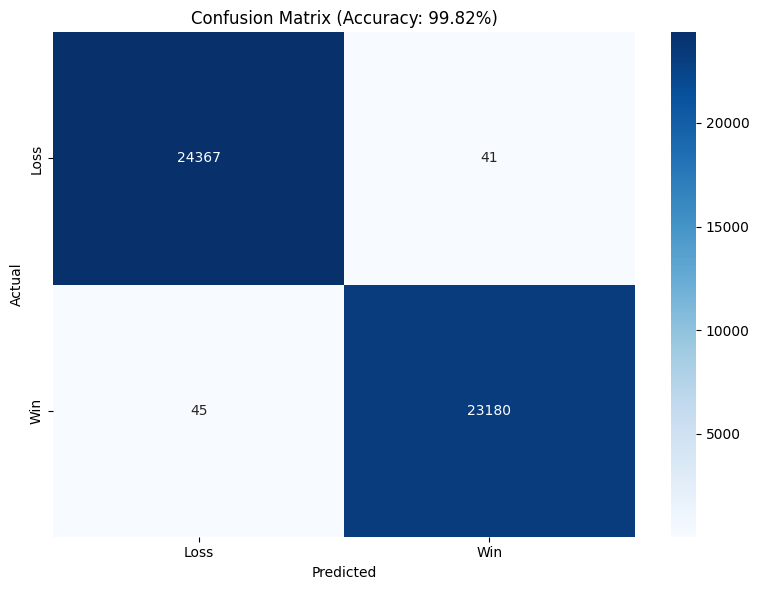

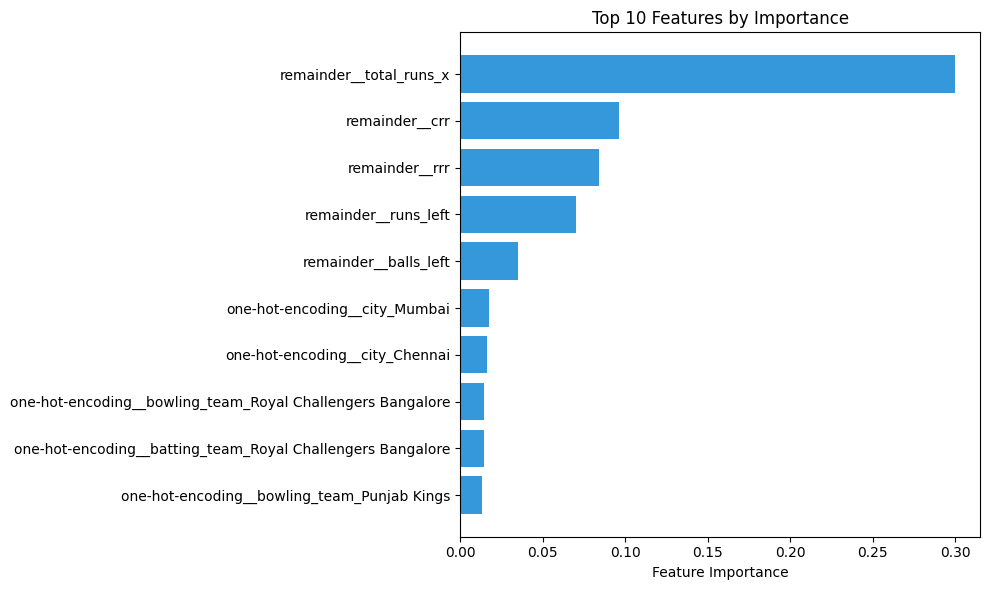

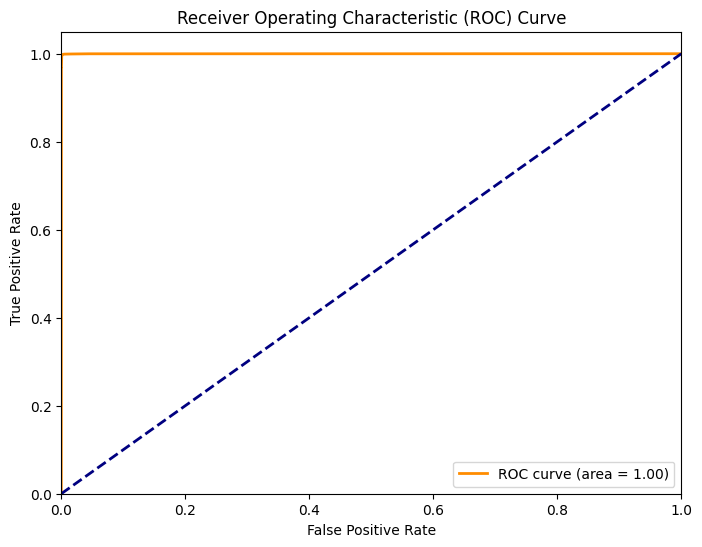

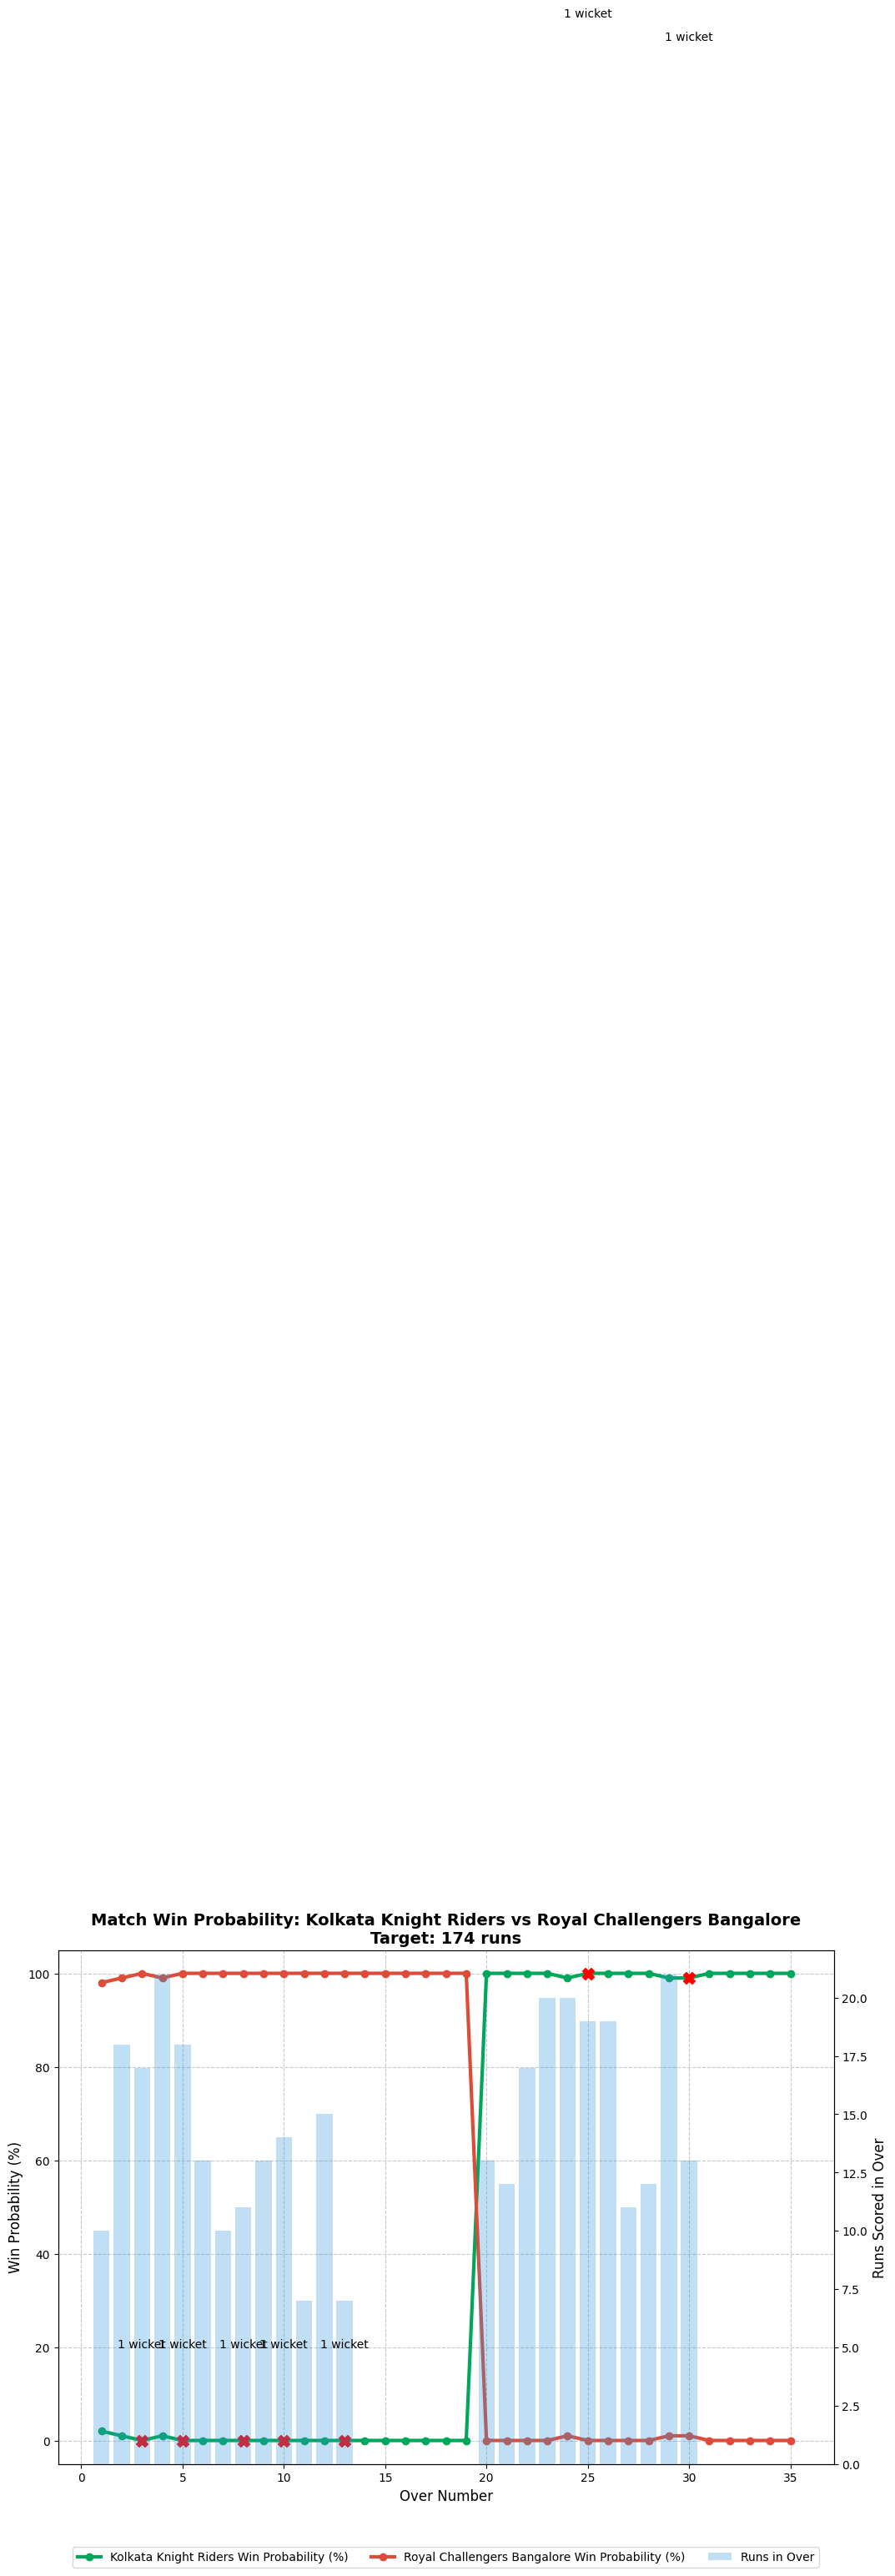

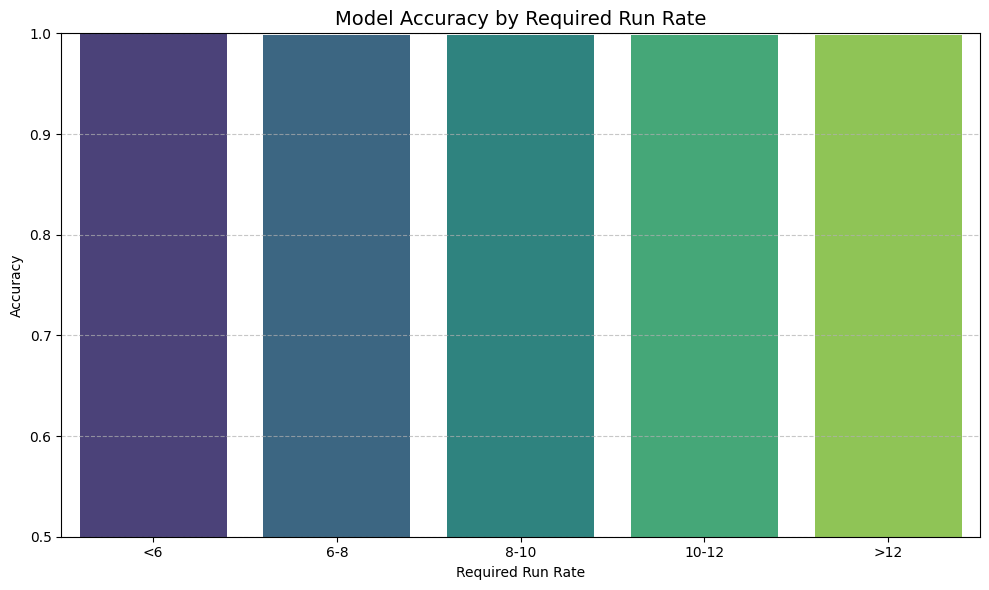

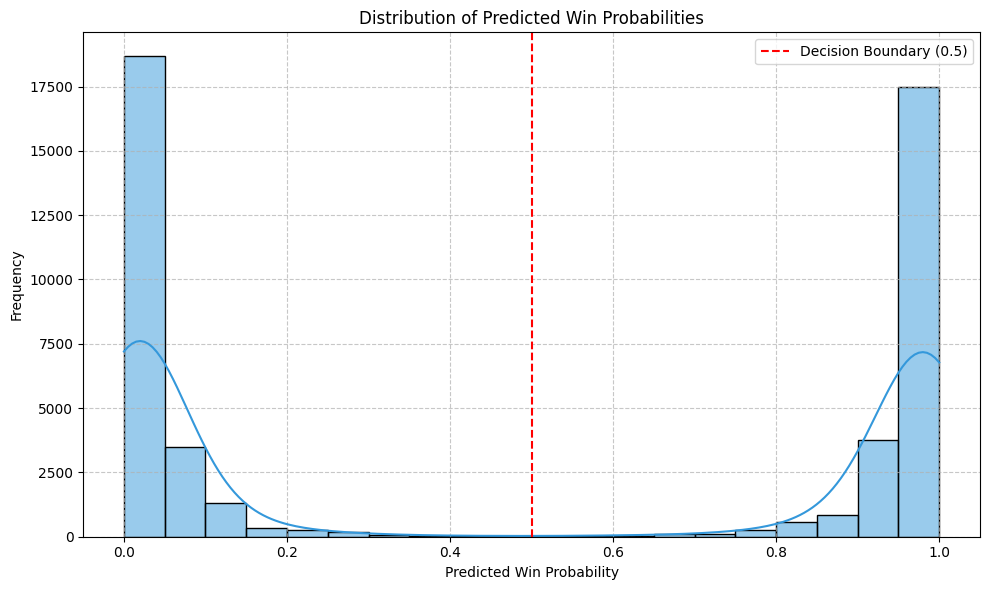

In [5]:
# Model Evaluation and Visualization for Presentation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


from joblib import load
pipe = load('model_new_2025.joblib')

# 2. Make predictions on test data
y_pred = pipe.predict(X_test)
y_pred_proba = pipe.predict_proba(X_test)

# 3. Calculate accuracy and create performance metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# 4. Create confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Loss', 'Win'], 
            yticklabels=['Loss', 'Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2%})')
plt.tight_layout()
plt.savefig('model_visualizations/confusion_matrix.png', dpi=300, bbox_inches='tight')

# 5. Create feature importance visualization
# For Random Forest, we can extract feature importance
model = pipe.named_steps['model']
features = pipe.named_steps['preprocessing'].get_feature_names_out()

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], color='#3498db')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features by Importance')
plt.tight_layout()
plt.savefig('model_visualizations/feature_importance.png', dpi=300, bbox_inches='tight')

# 6. Create ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('model_visualizations/roc_curve.png', dpi=300, bbox_inches='tight')

# 7. Win probability visualization (sample match)
# Let's visualize how win probability changes during a match

# Function to create dynamic win probability chart for presentation
def create_win_probability_chart(match_id=new_match_id):
    temp_df, target = match_progression(delivery_df, match_id, pipe)
    
    if temp_df is None:
        return None
    
    # Get match details for title
    match_details = delivery_df[delivery_df['match_id'] == match_id].iloc[0]
    batting_team = match_details['batting_team']
    bowling_team = match_details['bowling_team']
    
    plt.figure(figsize=(12, 8))
    
    # Plot win probability
    ax1 = plt.subplot(111)
    ax1.plot(temp_df['end_of_over'], temp_df['win'], 'o-', color='#00a65a', linewidth=3, 
             label=f'{batting_team} Win Probability (%)')
    ax1.plot(temp_df['end_of_over'], temp_df['lose'], 'o-', color='#dd4b39', linewidth=3, 
             label=f'{bowling_team} Win Probability (%)')
    
    # Plot runs per over as bars
    ax2 = ax1.twinx()
    ax2.bar(temp_df['end_of_over'], temp_df['runs_after_over'], alpha=0.3, color='#3498db', 
            label='Runs in Over')
    
    # Mark wickets with red points
    for over, wickets in zip(temp_df['end_of_over'], temp_df['wickets_in_over']):
        if wickets > 0:
            ax1.scatter(over, temp_df.loc[temp_df['end_of_over'] == over, 'win'].values[0], 
                       color='red', s=100, marker='X', zorder=5)
            plt.text(over, temp_df.loc[temp_df['end_of_over'] == over, 'win'].values[0] + 5, 
                    f"{wickets} wicket{'s' if wickets > 1 else ''}", ha='center')
    
    # Add gridlines and styling
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_xlabel('Over Number', fontsize=12)
    ax1.set_ylabel('Win Probability (%)', fontsize=12)
    ax2.set_ylabel('Runs Scored in Over', fontsize=12)
    
    # Title and legends
    plt.title(f'Match Win Probability: {batting_team} vs {bowling_team}\nTarget: {target} runs', 
              fontsize=14, fontweight='bold')
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', 
               bbox_to_anchor=(0.5, -0.15), ncol=3)
    
    plt.tight_layout()
    plt.savefig('model_visualizations/match_win_probability.png', dpi=300, bbox_inches='tight')
    return plt

# Create the win probability chart
chart = create_win_probability_chart()

# Let's analyze how model performs in different scenarios

# Create bins for remaining runs and balls
X_test_copy = X_test.copy()
X_test_copy['pred'] = y_pred
X_test_copy['actual'] = y_test.values

# Create bins for required run rate
X_test_copy['rrr_bin'] = pd.cut(X_test_copy['rrr'], 
                               bins=[0, 6, 8, 10, 12, 20], 
                               labels=['<6', '6-8', '8-10', '10-12', '>12'])

# Calculate accuracy by rrr bins
accuracy_by_rrr = X_test_copy.groupby('rrr_bin').apply(
    lambda x: accuracy_score(x['actual'], x['pred'])).reset_index()
accuracy_by_rrr.columns = ['Required Run Rate', 'Accuracy']

plt.figure(figsize=(10, 6))
sns.barplot(x='Required Run Rate', y='Accuracy', data=accuracy_by_rrr, palette='viridis')
plt.title('Model Accuracy by Required Run Rate', fontsize=14)
plt.ylim(0.5, 1.0)  # Adjust y-axis for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_visualizations/accuracy_by_rrr.png', dpi=300, bbox_inches='tight')

# Create a visualization of the prediction probability distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba[:, 1], bins=20, kde=True, color='#3498db')
plt.axvline(0.5, color='red', linestyle='--', label='Decision Boundary (0.5)')
plt.xlabel('Predicted Win Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Win Probabilities')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_visualizations/prediction_distribution.png', dpi=300, bbox_inches='tight')

print("All visualizations have been created and saved.")